In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import cm, colors

from ecomplexity import ecomplexity
from ecomplexity import proximity

In [2]:
# parameters
period = "2020-2021"

**1 - complexity related visuals**

In [3]:
# re-read to show top countries / languages from 2020
cdf = pd.read_csv(f"../outputs/complexity_table{period}.csv", sep=";")

In [4]:
cdf[["eci", "iso2_code"]].drop_duplicates().sort_values(by="eci", ascending=False).head(10)

,eci,iso2_code
5513,2.123035,DE
21158,2.081709,US
7152,2.076468,GB
7003,2.043101,FR
3576,2.026809,CA
4470,1.990240,CN
10132,1.979358,JP
15049,1.957423,NL
3874,1.947688,CH
1043,1.942703,AU


In [5]:
cdf[["eci", "iso2_code"]].drop_duplicates().sort_values(by="eci", ascending=False).tail(10)

,eci,iso2_code
8344,-1.175256,HT
12218,-1.175256,LY
13112,-1.175256,ML
14006,-1.175256,MV
14155,-1.175256,MW
11175,-1.175256,LA
3427,-1.217717,BZ
11622,-1.217717,LR
5066,-1.231908,CV
18923,-1.231908,SL


In [6]:
cdf[["pci", "language"]].drop_duplicates().sort_values(by="pci", ascending=False).head(20)

,pci,language
9,2.694587,Astro
39,2.643516,G-code
52,2.615574,Haml
1,2.615574,AMPL
62,2.607615,LLVM
66,2.607615,Logos
133,2.606060,Thrift
129,2.603794,SystemVerilog
10,2.588235,AutoHotkey
122,2.583043,SourcePawn


In [7]:
cdf[["pci", "language"]].drop_duplicates().sort_values(by="pci", ascending=False).tail(20)

,pci,language
16,0.109824,C#
3,0.076153,ASP.NET
130,0.059270,TSQL
82,-0.122230,Objective-C
135,-0.135629,TypeScript
117,-0.187651,Shell
63,-0.280616,Less
56,-0.389399,Java
61,-0.428593,Kotlin
51,-0.438381,Hack


In [8]:
def mcl_raw_matrix(df, key_columns, heatmap, size, ax=None):
    table = df[key_columns]
    
    table = pd.pivot_table(table,
        values=key_columns[2],
        index=key_columns[1],
        columns=key_columns[0],
        aggfunc=np.sum,
        margins=True,
        margins_name='total')

    table = table\
            .sort_values(by=["total"], ascending=False, axis=0)\
            .sort_values(by=["total"], ascending=False, axis=1)

    table = table.drop(["total"], axis=1).drop(["total"], axis=0)

    table = np.log10(table)
    table.replace([np.inf, -np.inf], 0, inplace=True)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(table, cbar=False, cmap="Blues", ax=ax)
        ax.set_xlabel("Countries", size=size)
        ax.set_ylabel("Languages", size=size)
        ax.set_xticklabels("")
        ax.tick_params("y", labelsize=size-15)
        ax.tick_params(left = False, bottom = False)

        my_cmap = plt.cm.get_cmap('Blues')
        colors = my_cmap(table.values.tolist())

        sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,table.values.max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, orientation="vertical", pad=0.1, shrink=0.9925, aspect=40, ax=ax)
        cbar.ax.set_ylabel("Number of pushers", size=size)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.tick_params(labelsize=size-5)
        cbar.set_ticks([0, 1, 2, 3, 4, 5, 6])
        cbar.set_ticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$'])

/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


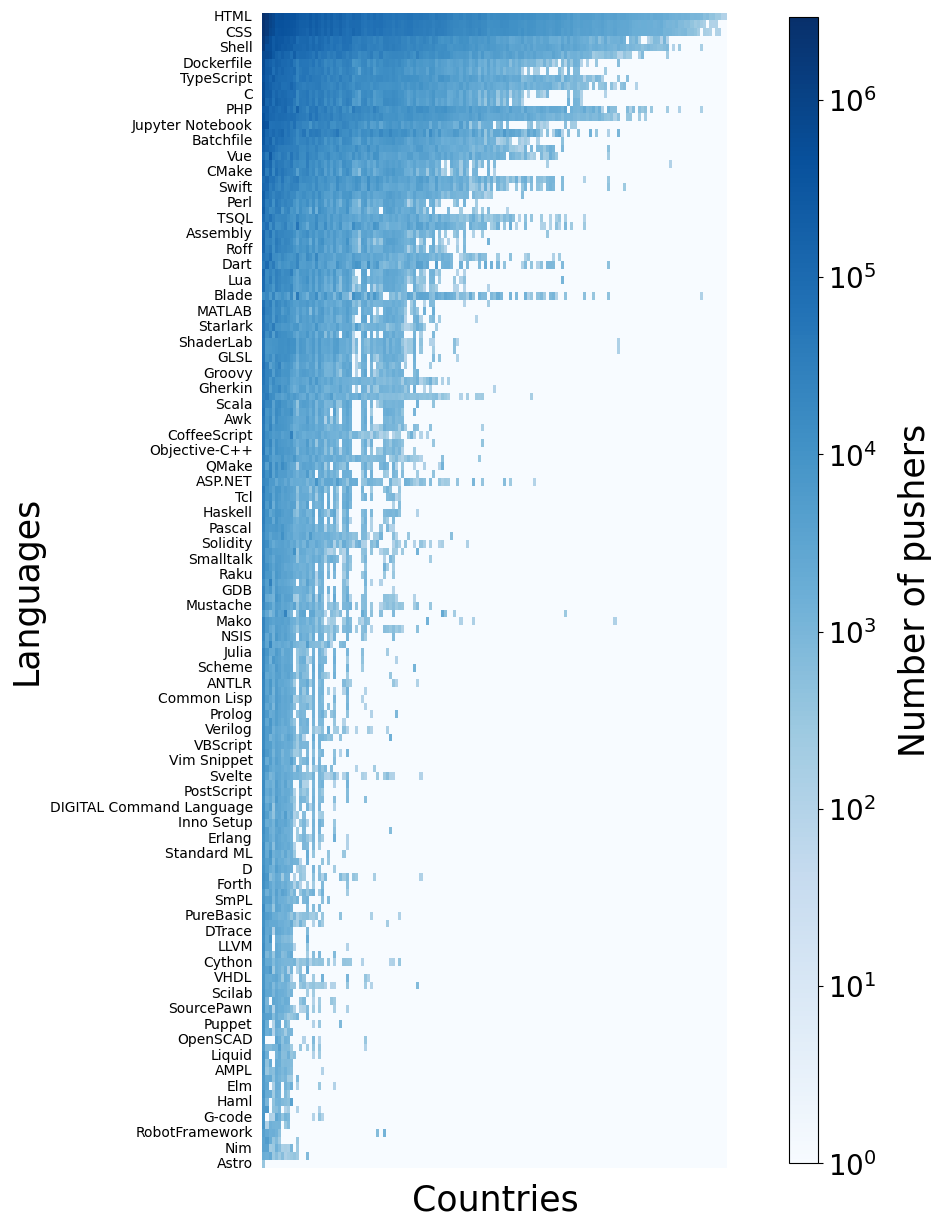

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8, 15))
mcl_raw_matrix(cdf, key_columns=["iso2_code", "language", "num_pushers"], heatmap=True, size=25, ax=ax)

In [10]:
def mcl_matrix(df, key_columns, heatmap, size, ax=None):
    table = df[key_columns]
    table.loc[table[key_columns[2]] >=1, key_columns[2]] = 1
    table.loc[table[key_columns[2]] < 1, key_columns[2]] = 0
    
    table = pd.pivot_table(table,
        values=key_columns[2],
        index=key_columns[1],
        columns=key_columns[0],
        aggfunc=np.sum,
        margins=True,
        margins_name='total')
    
    table = table\
        .sort_values(by=["total"], ascending=False, axis=0)\
        .sort_values(by=["total"], ascending=False, axis=1)

    table = table.drop(["total"], axis=1).drop(["total"], axis=0)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(table, cbar=False, cmap="Blues", ax=ax)
        ax.set_title("RCA", size=size+2)
        ax.set_xlabel("Countries", size=size)
        ax.set_ylabel("Languages", size=size)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)
        

In [11]:
def mcc_matrix(df, key_columns, heatmap, size=18, ax=None):
    mat = mcl_matrix(df, key_columns, heatmap=False, size=size).values
    t_mat = mat.transpose()

    mccp = np.dot(t_mat, mat)
    mccp = pd.DataFrame(mccp, columns=list(mcl_matrix(df, key_columns, heatmap=False, size=size).columns))

    if heatmap==False:
        return mccp
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(mccp, cbar=False, cmap="Blues", ax=ax)
        ax.set_title("Mcc' ", size=size)
        ax.set_xlabel("Countries", size=size)
        ax.set_ylabel("Countries", size=size)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)


def mll_matrix(df, key_columns, heatmap, size, ax=None):
    mat = mcl_matrix(df, key_columns, heatmap=False, size=size).values
    t_mat = mat.transpose()
    mllp = np.dot(mat, t_mat) 
    mllp = pd.DataFrame(mllp, columns=list(mcl_matrix(df, key_columns, heatmap=False, size=size).index))

    if heatmap==False:
        return mllp
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(mllp, cbar=False, cmap="Blues", ax=ax)
        ax.set_title("Mll' ", size=size+2)
        ax.set_xlabel("Languages", size=size)
        ax.set_ylabel("Languages", size=size)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)



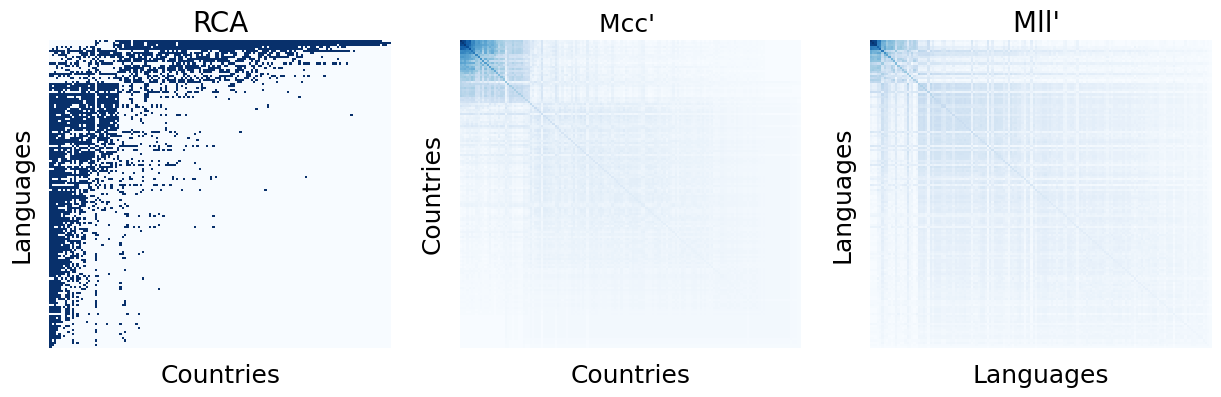

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
mcl_matrix(cdf, key_columns=["iso2_code", "language", "rca"], heatmap=True, size=18, ax=ax[0])
mcc_matrix(cdf, key_columns=["iso2_code", "language", "rca"], heatmap=True, size=18, ax=ax[1])
mll_matrix(cdf, key_columns=["iso2_code", "language", "rca"], heatmap=True, size=18, ax=ax[2])

In [13]:
def diversity_avg_ubiquity_complexity_scatter(df, ax=None):
    rca01 = df["rca"] >= 1
    df["rca01"] = rca01.astype(int) 
    df["w_ubi"] = df["rca01"] * df["ubiquity"]
    df["sum_w_ubi"] = df.groupby(["iso2_code"])["w_ubi"].transform("sum")    
    df["nr_rca01"] = df.groupby(["iso2_code"])["rca01"].transform("sum")
    df["mean_ubi"] = df["sum_w_ubi"] / df["nr_rca01"]

    df = df[["iso2_code", "eci", "diversity", "mean_ubi"]].drop_duplicates()
    #df["eci"] = (df["eci"] - df["eci"].min()) / (df["eci"].max() - df["eci"].min())

    vmin = min(df["eci"])
    vmax = max(df["eci"])
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
    eci_values = mapper.to_rgba(df["eci"].to_list())

    if ax is None:
        ax = plt.gca()
    ax.scatter(df["diversity"], df["mean_ubi"], color=eci_values, s=55)
    ax.set_xlabel("Language diversity", size=20)
    ax.set_ylabel("Average language ubiquity", size=20)
    ax.tick_params("x", labelsize=15)
    ax.tick_params("y", labelsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    cbar = fig.colorbar(mapper, pad=0.02, shrink=0.975, ax=ax)
    cbar.ax.set_ylabel('Software complexity', rotation=90, labelpad=15, fontsize=20)
    cbar.ax.tick_params(labelsize=15)

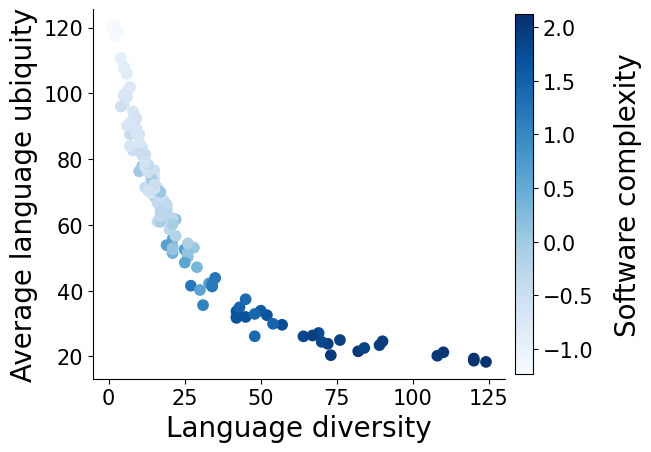

In [14]:
diversity_avg_ubiquity_complexity_scatter(cdf)

In [17]:
def ubiquity_avg_diversity_complexity_scatter(df, ax=None):
    rca01 = df["rca"] >= 1
    df["rca01"] = rca01.astype(int) 
    df["w_div"] = df["rca01"] * df["diversity"]
    df["sum_w_div"] = df.groupby(["language"])["w_div"].transform("sum")
    df["nr_rca01"] = df.groupby(["language"])["rca01"].transform("sum")
    df["mean_div"] = df["sum_w_div"] / df["nr_rca01"]

    df = df[["language", "pci", "ubiquity", "mean_div"]].drop_duplicates()

    vmin = min(df["pci"])
    vmax = max(df["pci"])
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
    pci_values = mapper.to_rgba(df["pci"].to_list())

    if ax is None:
        ax = plt.gca()
    ax.scatter(df["ubiquity"], df["mean_div"], color=pci_values, s=55)
    ax.set_xlabel("Language ubiquity", size=20)
    ax.set_ylabel("Average language diversity", size=20)
    ax.tick_params("x", labelsize=15)
    ax.tick_params("y", labelsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    cbar = fig.colorbar(mapper, pad=0.02, shrink=0.975, ax=ax)
    cbar.ax.set_ylabel('Language complexity', rotation=90, labelpad=15, fontsize=20)
    cbar.ax.tick_params(labelsize=15)

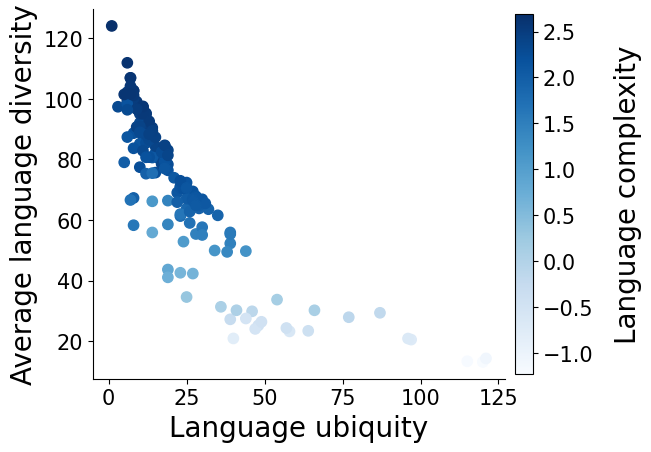

In [18]:
ubiquity_avg_diversity_complexity_scatter(cdf)

In [19]:
def complexity_complexity_matrix(df, heatmap, ax=None):
    # to sort location by eci
    location_sorter = df[["iso2_code", "eci"]]\
        .drop_duplicates()\
        .sort_values(by="eci", ascending=False)

    # only categories w/ RCA
    table = df[df["rca"] >= 1]
    table = table[["iso2_code", "language", "pci"]].drop_duplicates()
    
    table = pd.pivot_table(table,
        values="pci",
        index=["iso2_code"],
        columns=["language"],
        aggfunc=np.mean,
        margins=True,
        margins_name='total')
    
    # add the location_sorter and sort
    table = pd.merge(
        table,
        location_sorter,
        on="iso2_code",
        how="left"
    )

    table = table.sort_values(by=["eci"], ascending=False, axis=0)\
        .set_index("iso2_code")\
        .sort_values(by=["total"], ascending=False, axis=1)

    # remove supporter rows and cols
    table = table.drop(["eci"], axis=1).drop(["total"], axis=1).drop(["total"], axis=0)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()

    sns.heatmap(table, cbar=False, cmap="Blues", ax=ax)
    ax.set_xlabel("Languages sorted by \n their complexity", size=20)
    ax.set_ylabel("Countries sorted by \n their complexity", size=20)
    #ax.set_xticklabels("")
    #ax.set_yticklabels("")
    ax.tick_params(left = False, bottom = False)

    # colorbar settings
    vmin = min(df["pci"])
    vmax = max(df["pci"])
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
    cbar = fig.colorbar(mapper, shrink=0.975, pad=0.02, ax=ax)
    cbar.ax.set_ylabel('Software complexity', rotation=90, labelpad=15, fontsize=20)
    cbar.ax.tick_params(labelsize=15)

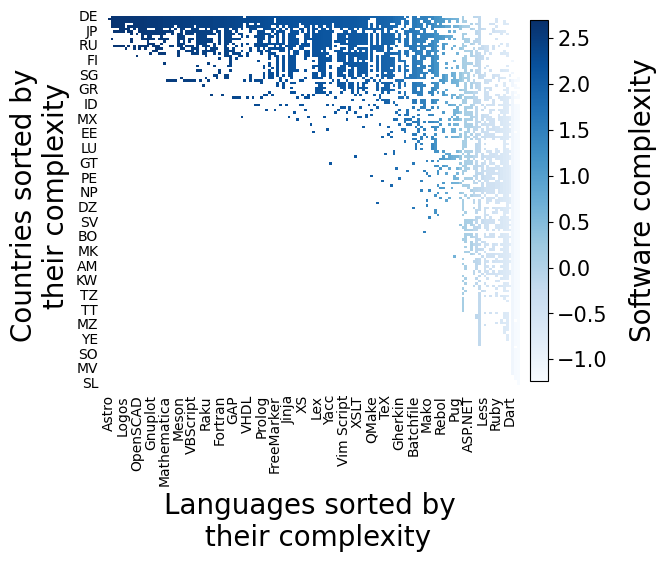

In [20]:
complexity_complexity_matrix(cdf, heatmap=True)

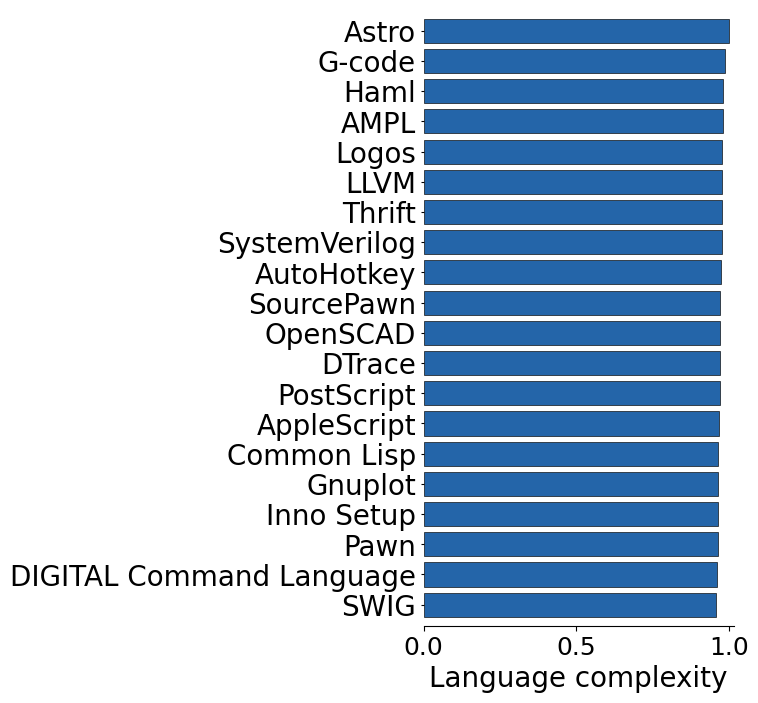

In [21]:
def poi_complexity_plot_top10(data, label_size, ax=None):
    data = data[["language", "pci"]].drop_duplicates()
    data["pci_norm"] = (data["pci"] - data["pci"].min()) / (data["pci"].max() - data["pci"].min())
    data = data.sort_values(by=["pci_norm"], ascending=True)
    data = data.iloc[-20:,]

    if ax is None:
        ax = plt.gca()
    ax.barh(data["language"], data["pci_norm"], color="#2465a9", edgecolor="black", linewidth=0.45)

    ax.margins(0.015, tight=True)
    ax.set_xlabel("Language complexity", size=label_size)
    ax.tick_params("y", size=2, labelsize=label_size)
    ax.tick_params("x", labelsize=label_size-2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(4,8))
poi_complexity_plot_top10(cdf, label_size=20, ax=ax)

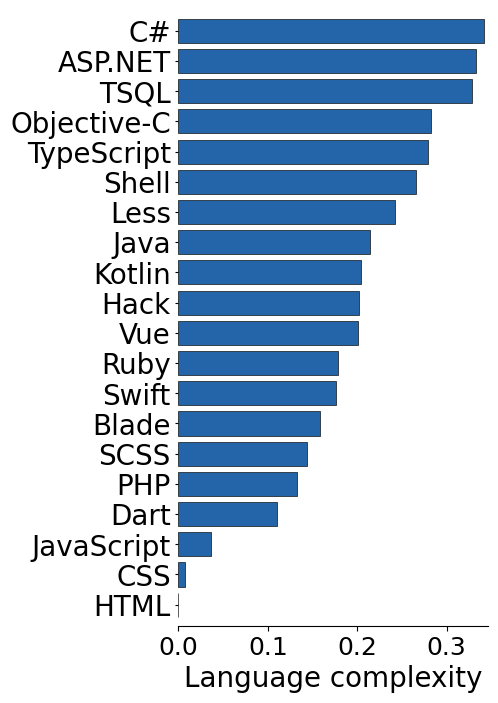

In [22]:
def poi_complexity_plot_bottom10(data, label_size, ax=None):
    data = data[["language", "pci"]].drop_duplicates()
    data["pci_norm"] = (data["pci"] - data["pci"].min()) / (data["pci"].max() - data["pci"].min())
    data = data.sort_values(by=["pci_norm"], ascending=False)
    data = data.iloc[-20:,].sort_values(by=["pci_norm"], ascending=True)

    if ax is None:
        ax = plt.gca()
    ax.barh(data["language"], data["pci_norm"], color="#2465a9", edgecolor="black", linewidth=0.45)

    ax.margins(0.015, tight=True)
    ax.set_xlabel("Language complexity", size=label_size)
    ax.tick_params("y", size=2, labelsize=label_size)
    ax.tick_params("x", labelsize=label_size-2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(4,8))
poi_complexity_plot_bottom10(cdf, label_size=20, ax=ax)

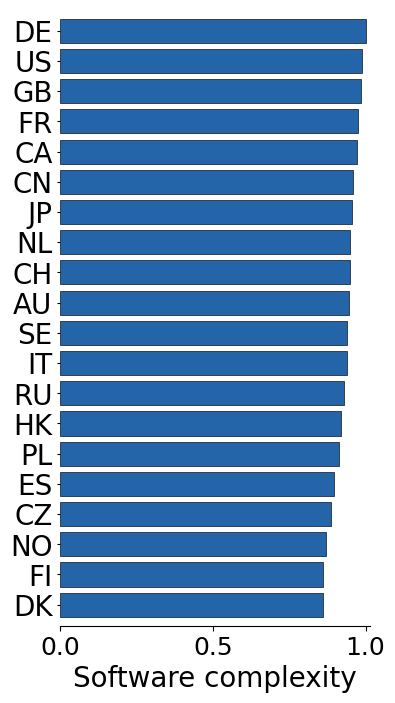

In [23]:
def software_complexity_plot_top10(data, label_size, ax=None):
    data = data[["iso2_code", "eci"]].drop_duplicates()
    data["eci_norm"] = (data["eci"] - data["eci"].min()) / (data["eci"].max() - data["eci"].min())
    data = data.sort_values(by=["eci_norm"], ascending=True)
    data = data.iloc[-20:,]

    if ax is None:
        ax = plt.gca()
    ax.barh(data["iso2_code"], data["eci_norm"], color="#2465a9", edgecolor="black", linewidth=0.45)

    ax.margins(0.015, tight=True)
    ax.set_xlabel("Software complexity", size=label_size)
    ax.tick_params("y", size=2, labelsize=label_size)
    ax.tick_params("x", labelsize=label_size-2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(4,8))
software_complexity_plot_top10(cdf, label_size=20, ax=ax)

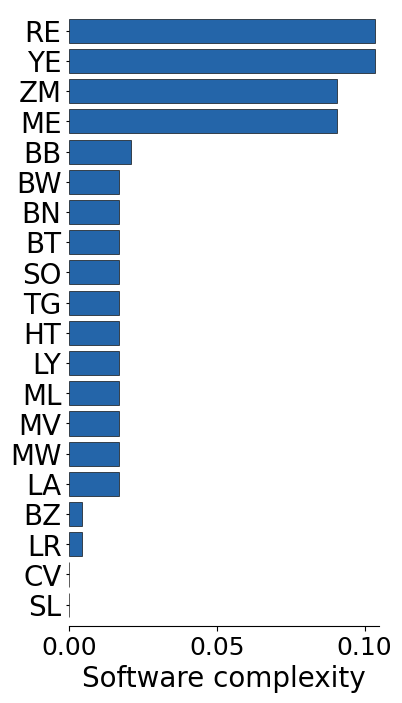

In [24]:
def software_complexity_plot_bottom10(data, label_size, ax=None):
    data = data[["iso2_code", "eci"]].drop_duplicates()
    data["eci_norm"] = (data["eci"] - data["eci"].min()) / (data["eci"].max() - data["eci"].min())
    data = data.sort_values(by=["eci_norm"], ascending=False)
    data = data.iloc[-20:,].sort_values(by=["eci_norm"], ascending=True)

    if ax is None:
        ax = plt.gca()
    ax.barh(data["iso2_code"], data["eci_norm"], color="#2465a9", edgecolor="black", linewidth=0.45)

    ax.margins(0.015, tight=True)
    ax.set_xlabel("Software complexity", size=label_size)
    ax.tick_params("y", size=2, labelsize=label_size)
    ax.tick_params("x", labelsize=label_size-2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(4,8))
software_complexity_plot_bottom10(cdf, label_size=20, ax=ax)

**2 - github space related visuals**

In [25]:
# github space
space_df = pd.read_csv(f"../outputs/software_space_edgelist{period}.csv", sep=";")

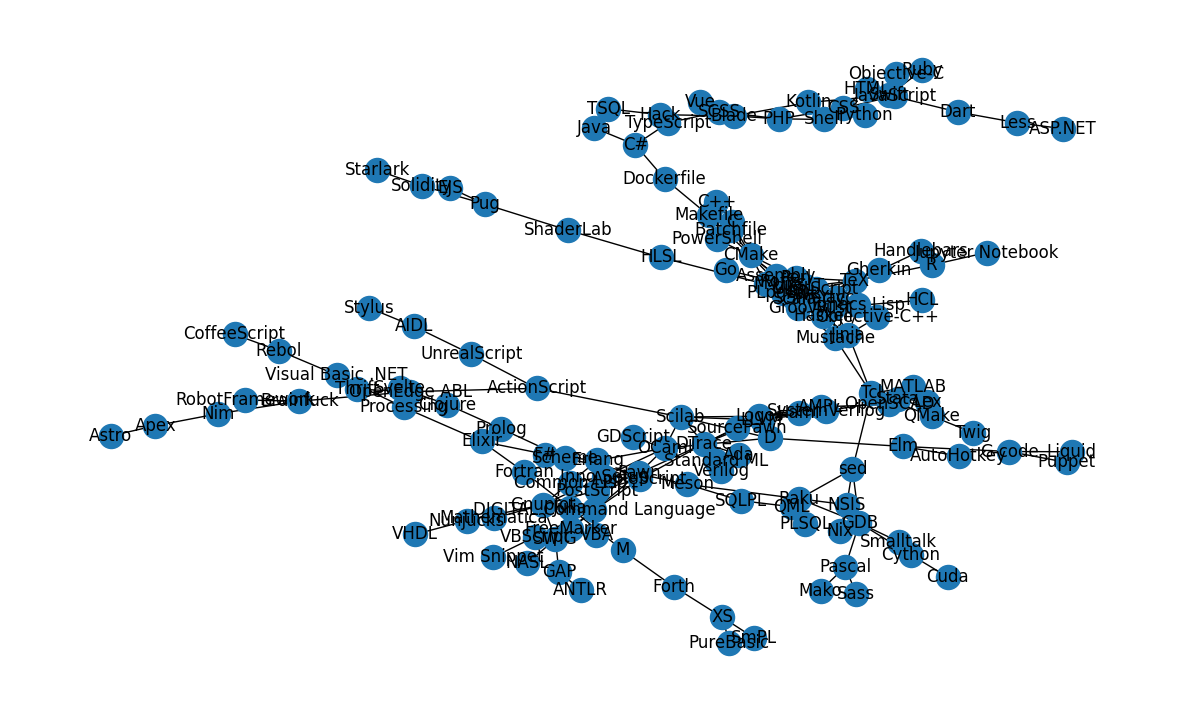

In [26]:
# network visual -- maximum spanning tree
language_graph = nx.from_pandas_edgelist(space_df, source="language_1", target="language_2")

fig, ax = plt.subplots(1,1, figsize=(15,9))
nx.draw(language_graph, with_labels=True, ax=ax)